In [22]:
import pandas as pd
import numpy as np
import seaborn as sns

from datetime import datetime, timedelta
from pandas.tseries.holiday import USFederalHolidayCalendar

from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import normalize, minmax_scale
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from scipy.stats import skew
from scipy import stats
from sklearn.model_selection import cross_val_score, train_test_split


### Load data provided by PJM 
From: https://www.pjm.com/-/media/library/reports-notices/special-reports/2018/2018-emissions-report.ashx?la=en 

In [2]:
calc = pd.read_csv("pjm-mefs.csv")
calc.head()

,year,month,mef
0,2014,1,1194
1,2014,2,1212
2,2014,3,1187
3,2014,4,1088
4,2014,5,1049


### Updated Regression with More Data

In [4]:
# Label the df with the year, month, hour, and season 
def label_year_month(df):
    df = df.copy()
    df['year'] = df.index.year
    df['month'] = df.index.month
    return df

In [21]:
# Load ISO/RTO data, focus on PJM 
isorto_data1 = pd.read_csv("../data/formatted_data/cems_diffs_isorto.csv", index_col=0, parse_dates=[0])

isorto_data1 = isorto_data1.loc[isorto_data1['isorto'] == 'PJM']
isorto_data1 = label_year_month(isorto_data1)

In [6]:
# Group by year and month
data = isorto_data1.copy()
data = data.groupby(['year', 'month']).sum()
data = data.reset_index()

# Get MEF from PJM then find the MEF from the last hour
df = pd.merge(data, calc, how='left', on=['year', 'month'])
df['prev_co2_mef'] = df.mef.shift(1)
df = df.dropna()
df = df.drop_duplicates(subset=['year', 'month'], keep='first')

df.head()

,year,month,gload_mwh,so2_kg,nox_kg,pm25_kg,co2_kg,so2_dam_ap2,nox_dam_ap2,pm25_dam_ap2,so2_dam_eas,nox_dam_eas,pm25_dam_eas,co2_dam,mef,prev_co2_mef
97,2014,2,5647.59,10323.889090,-466.319792,924.240078,4.267650e+06,776174.03,-28554.01,92361.37,319667.88,2034.64,98118.76,170705.98,1212.0,1194.0
98,2014,3,-32157.09,-70378.294180,-20399.731396,-3803.826705,-2.411806e+07,-3081483.55,-141013.79,-448314.41,-1974977.20,-177466.55,-370857.78,-964722.23,1187.0,1212.0
99,2014,4,2646.89,-4906.113668,-642.892271,539.593638,1.897115e+06,-398123.34,3383.34,80831.65,-176736.42,-11395.68,49825.73,75884.61,1088.0,1187.0
100,2014,5,-1343.98,3731.214226,-3248.661738,-410.591931,-1.322843e+06,20919.60,-21059.36,-54530.17,143005.35,-32421.36,-41787.80,-52913.70,1049.0,1088.0
101,2014,6,24450.74,38175.641724,17567.597748,2801.205843,1.905340e+07,1860962.54,146635.43,324328.58,1048241.79,153047.68,268462.48,762135.95,1116.0,1049.0


In [7]:
# sin / cosine correction for month 
df['cos_month'] = np.cos((df.month)*(2*np.pi/12))
df['sin_month'] = np.sin((df.month)*(2*np.pi/12))

In [8]:
# Start with CO2 Calculations
x = df[['year', 'sin_month', 'cos_month', 'so2_kg', 'nox_kg', 'pm25_kg', 'gload_mwh', 'prev_co2_mef']]
y = df[['mef']]

# Normalize x 
# x = (x-x.min())/(x.max()-x.min())
# x.head()

In [9]:
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size = 0.2,random_state = 100) 
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [10]:
# Make predictions using the testing set
results = pd.DataFrame(index = x.index)
results['mef_predicted'] = lr.predict(x)
results['mef_actual'] = y['mef']

results.index = range(35)

In [20]:
# Calculate error: sum of (y - y(hat)) / y(hat)^2 
temp = pd.DataFrame()
temp['diff'] = abs(results['mef_actual'] - results['mef_predicted'])
temp['error'] = temp['diff'] / (results['mef_predicted']**2)
print("Test and training error: " + str(temp['error'].sum()))

# Test data 
test = pd.DataFrame(index = X_test.index)
test['mef_predicted'] = lr.predict(X_test)
test['mef_actual'] = y_test['mef']
test['diff'] = abs(test['mef_actual'] - test['mef_predicted'])
test['error'] = test['diff'] / (test['mef_predicted']**2)
print("Test error: " + str(test['error'].sum()))

# Training data 
train = pd.DataFrame(index = X_train.index)
train['mef_predicted'] = lr.predict(X_train)
train['mef_actual'] = y_train['mef']
train['diff'] = abs(train['mef_actual'] - train['mef_predicted'])
train['error'] = train['diff'] / (train['mef_predicted']**2)
print("Test error: " + str(train['error'].sum()))

Overall error: 0.0017104682470151272
Test error: 0.000513071835639028
Test error: 0.0011973964113760993


### Compare with univariate regression model
Results of this paper: https://pubs.acs.org/doi/10.1021/acs.est.8b06586

In [12]:
df_compare = pd.read_csv("mef-regression.csv", index_col=0)
df_compare = df_compare.loc[df_compare['pollutant'] == 'co2']

df_compare = df_compare[['year', 'month', 'factor']]
df_compare = df_compare[df_compare['year'].isin(['2014', '2015', '2016'])]

df_compare.columns = ['year', 'month', 'mef_paper']
df_compare.index = range(35)

In [13]:
df_compare = df_compare.join(results)
df_compare

,year,month,mef_paper,mef_predicted,mef_actual
0,2014,2,600.735353,1140.850978,1212.0
1,2014,3,653.488770,1044.788224,1187.0
2,2014,4,674.639737,1154.299142,1088.0
3,2014,5,671.333305,1012.433430,1049.0
4,2014,6,686.015935,1141.402267,1116.0
5,2014,7,689.249095,1036.655925,1121.0
6,2014,8,708.448409,1098.453735,1092.0
7,2014,9,696.836722,1048.589230,1059.0
8,2014,10,703.063725,1058.517738,1017.0
9,2014,11,672.504285,995.793382,1077.0


In [35]:
df_graph = df_compare.melt(id_vars=["year", "month"], 
        var_name="Type", 
        value_name="mef")

df_graph['date'] = df_graph["year"].astype(str) + "-" + df_graph["month"].astype(str)
df_graph['date'] = pd.to_datetime(df_graph['date'])
df_graph

,year,month,Type,mef,date
0,2014,2,mef_paper,600.735353,2014-02-01
1,2014,3,mef_paper,653.488770,2014-03-01
2,2014,4,mef_paper,674.639737,2014-04-01
3,2014,5,mef_paper,671.333305,2014-05-01
4,2014,6,mef_paper,686.015935,2014-06-01
...,...,...,...,...,...
100,2016,8,mef_actual,1109.000000,2016-08-01
101,2016,9,mef_actual,1047.000000,2016-09-01
102,2016,10,mef_actual,973.000000,2016-10-01
103,2016,11,mef_actual,895.000000,2016-11-01


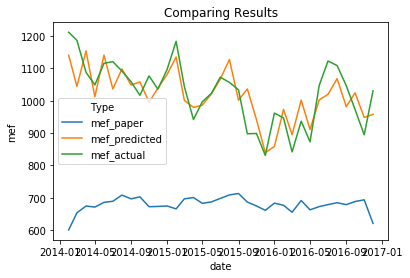

In [36]:
sns.lineplot(x='date', y="mef", hue="Type", data=df_graph)

plt.title("Comparing Results")
plt.show()

In [14]:
# Error from the paper compared to the real value 
temp = pd.DataFrame()
temp['diff'] = abs(df_compare['mef_actual'] - df_compare['mef_paper'])
temp['error'] = temp['diff'] / (df_compare['mef_paper']**2)
temp['error'].sum()

0.02664012203405804

### Lasso

In [25]:
lasso = Lasso()
lasso.fit(X_train,y_train)
train_score=lasso.score(X_train,y_train)
test_score=lasso.score(X_test,y_test)
coeff_used = np.sum(lasso.coef_!=0)
print("training score:", train_score )
print("test score: ", test_score)
print("number of features: ", len(X_train.columns))
print("number of features used: ", coeff_used)

training score: 0.6795023202430606
test score:  0.06352683046007068
number of features:  8
number of features used:  8
